# Walkthrough: Data Collection, Data Processing, and Forecast Modeling

<br>

# Description

This notebook details the methodology used to evaluate the predictive performance of the underlying forecasting models in the Residential Energy Demand Forecasting Pipeline. It also produces several figures and tables that are displayed by the project's web application. The following cell imports the necessary libraries.

In [2]:
# used to reload project modules when making changes
%load_ext autoreload 
%autoreload 2

# import third-party packages
import pandas as pd
import pickle as pkl
from scipy.stats import wilcoxon
import plotly.graph_objects as go
import os
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import modules from project repository
import get_data as gd
import preprocessing as pp
import model_definitions as md

The following two variables help guide what happens in the rest of the notebook.

In [3]:
# this variable determines where to look for saved datasets, models, and figures.
saved_data_directory = "Saved"

# this variable determines whether a saved model is loaded from the saved_data_directory or whether a new model is fit below.
load_model = True

### Defining the model 

If a model has already been fit (in the other walkthrough-style notebook) and has been saved in the local project repository, it can be loaded below. Otherwise, a new model needs to be trained. The cell below does one of these depending on the variables defined above and whether there is a saved model in the local project repository.

In [4]:
model_path = r"{}/Models/forecaster.pkl".format(saved_data_directory) # where the saved model should be

# load existing model
if load_model and os.path.exists(model_path): 
    with open(model_path, "rb") as file:
        model = pkl.load(file)

# fit new model
else: 
    # load in clean dataset
    clean_data = pd.read_csv(r"Saved/Datasets/clean_training.csv", index_col=0)
    clean_data.index = pd.to_datetime(clean_data.index)
    clean_data.loc[clean_data["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"

    # define model
    model = md.Forecaster(short_term_horizon=24)

    # define model hyperparameters
    best_pv_hyperparameters = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'point_var_lags': 10, 'minimum_error_prediction': 100, 'error_trend': 100}
    best_lstm_hyperparameters = {"batch_size":100, "lr":0.0005, "dropout":0.1, "num_layers":1, "hidden_size":32, "sequence_length":24*7*3, "max_epochs":100}

    # fit model
    warnings.filterwarnings('ignore')
    model.fit(clean_training_data=clean_data, dependent_variable="Energy Demand (MWH)", 
        hyperparameters=best_pv_hyperparameters | best_lstm_hyperparameters, verbose=False)

<br>

# Evaluating the Model on Holdout Data

With a final optimized forecasting model defined, it is important to evaluate its performance on unseen data and to contextualize that performance by comparing it with the performance of a baseline model. Below, we load the holdout dataset that was set aside during the processing phase of the pipeline and use it to evaluate the final forecasting model. The *Forecaster* class produces one-shot (or long-term) forecasts when the *long_term_predict* function is called and given a *hours_ahead* number of forecasts to predict. It returns both point forecasts and variance forecasts which can be used to create confidence intervals or relative confidence measures for each point forecasts. Similarly, the *Forecaster* class produces updated (or short-term) forecasts when the *short_term_predict* function is called and given a dataset of input variables (with the same format as the dataset used to train the model). These short-term forecasts utilize the short-term forecasting horizon with which the *Forecaster* object was defined and are also made up of both point forecasts and variance forecasts. 

Below, we load in the evaluation data and process it using the PreprocessingPipeline established in the other walkthrough notebook.

### Evaluate Long-term Forecasting Performance

In [5]:
# load holdout data
evaluation_data = pd.read_csv(r"Saved/Datasets/holdout.csv", index_col=0)
evaluation_data.index = pd.to_datetime(evaluation_data.index)

# process holdout data
processor_path = r"{}/Models/processor.pkl".format(saved_data_directory)

# load existing processor (this is needed to process evaluation data)
with open(processor_path, "rb") as file:
    processor = pkl.load(file)
    processor.produce_eda_plots = False

# process the evaluation data
evaluation_data, _ = processor.process_dataset(evaluation_data, train=False)
evaluation_data.loc[evaluation_data["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"

Interpolating for variable Energy Demand (MWH)
Interpolating for variable HourlyDryBulbTemperature
Interpolating for variable HourlyDewPointTemperature
Interpolating for variable HourlyWetBulbTemperature
Interpolating for variable HourlyStationPressure
Interpolating for variable HourlyWindSpeed
Interpolating for variable Energy Price (cents/KWH)
Interpolating for variable Civilian Noninstitutional Population
Interpolating for variable Labor Force Participation
Interpolating for variable CPI-U
Interpolating for variable HourlyPrecipitation


Now we can use the model to produce one-shot or long-term forecasts on the processed evaluation data.

In [23]:
# get complete range to be predicted (in case the holdout set is missing any values)
complete_range = pd.date_range(start=evaluation_data.index.min(), end=evaluation_data.index.max(), freq='H')

# produce long-term forecasts
lt_forecasts = model.long_term_predict(complete_range.shape[0])

# reconcile forecasts and ground truth values
results = pd.merge(lt_forecasts, evaluation_data, left_index=True, right_index=True, how="inner")
point_forecasts = results["Point Forecasts"].values
variance_forecasts = results["Variance Forecasts"].values
actual_values = results["Energy Demand (MWH)"]

# show what the probabilistic forecasts look like
display(lt_forecasts)

,Point Forecasts,Variance Forecasts
ds,,
2023-09-26 02:00:00,5058.668979,523694.853698
2023-09-26 03:00:00,4823.298297,505916.568351
2023-09-26 04:00:00,4553.842688,491535.171140
2023-09-26 05:00:00,4286.278903,476529.000086
2023-09-26 06:00:00,4049.996463,461264.755147
...,...,...
2024-04-26 20:00:00,5240.633086,544014.720262
2024-04-26 21:00:00,5243.536653,560990.302909
2024-04-26 22:00:00,5222.809125,552334.767595


### Plotting the long-term evaluation forecasts

Below, we plot the one-shot or long-term forecasts made by the model on our holdout evaluation data. This plot contains the point forecasts of the model, the upper and lower 95% prediction intervals (based on the model's variance forecasts), and the ground truth energy demand values for comparison. The evaluation data does span a large period of time, so it may be necessary to zoom in to distinguish between the different lines.

In [26]:
# Combine error forecasts
std_forecasts = np.sqrt(variance_forecasts)

# 1.96 is the z-value for the 2.5th percentile of the standard normal distribution
lower_cuts = point_forecasts - 1.96 * std_forecasts  
upper_cuts = point_forecasts + 1.96 * std_forecasts

# Create figure showing forecasts and actual values
long_term_fig = go.Figure()
long_term_fig.add_trace(go.Scatter(x=evaluation_data.index, y=point_forecasts, mode='lines', 
    name='Point Forecasts', line=dict(color='rgba(255, 0, 0)')))
long_term_fig.add_trace(go.Scatter(x=evaluation_data.index, y=actual_values, mode='lines', 
    name='Ground Truth', line=dict(color='rgba(0, 0, 255)')))
long_term_fig.add_trace(go.Scatter(x=evaluation_data.index, y=upper_cuts, mode='lines', 
    name='Upper 95 CI', line=dict(color='rgba(0, 255, 0, 0.2)')))
long_term_fig.add_trace(go.Scatter(x=evaluation_data.index, y=lower_cuts, mode='lines', 
    name='Lower 95 CI', line=dict(color='rgba(200, 125, 200, 0.2)')))

# Customize the layout
long_term_fig.update_layout(
    title="Long-term Evaluation of Forecasting Pipeline with Holdout Data",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark' 
)

# save plotly figure for web application
with open(r"assets/long_term_evaluation_plot.pkl", 'wb') as file:
    pkl.dump(long_term_fig, file=file)

long_term_fig.show()

### Statistical evaluation of long-term forecasts

While the Prophet-VAR portion of the *Forecaster* were fit using an MSE loss metric, it can be useful to evaluate the model using different metrics in order to see how accurate the model is from different perspectives. It is also useful to compare the model's performance against some kind of baseline. For our purpose, we are going to compare the accuracy of the *Forecaster* against a baseline yearly moving average. A Wilcoxon signed rank test is used to determine whether there is sufficient evidence to conclude that the *Forecaster* model's point forecasts are consistently more accurate than the baseline moving average.

In [45]:
### statistical comparison between baseline forecasting model and created forecasting model ###

# define baseline model as simple year-long moving average
clean_data = pd.read_csv(r"{}/Datasets/clean_training.csv".format(saved_data_directory), index_col=0)
sma = clean_data["Energy Demand (MWH)"].rolling(window=24*365).mean()
baseline_prediction = sma.iloc[-1]
sma_error = pd.merge(clean_data["Energy Demand (MWH)"], sma, left_index=True, right_index=True, 
    how="inner", suffixes=["_actual", "_baseline_prediction"])
sma_error = sma_error[sma_error["Energy Demand (MWH)_baseline_prediction"].notna()]
sma_variance = pd.Series((sma_error["Energy Demand (MWH)_baseline_prediction"] - 
    sma_error["Energy Demand (MWH)_actual"]).values**2).rolling(window=24*365).mean()
baseline_variance = sma_variance.iloc[-1]

# calculate errors from baseline model
baseline_errors = actual_values - baseline_prediction

# calculate errors from project model
model_errors = actual_values - point_forecasts

### calculate all measures for Forecasting Pipeline's long-term forecasts ###
# mse
pipeline_lt_mse = np.sum((model_errors**2))/model_errors.shape[0]

# wmse
relative_confidence = 1/std_forecasts
relative_confidence = relative_confidence/np.sum(relative_confidence) * relative_confidence.shape[0]
pipeline_lt_wmse = np.sum(relative_confidence * 
    (point_forecasts - actual_values)**2)/actual_values.shape[0]

# mae
pipeline_lt_mae = np.sum(np.abs(model_errors))/model_errors.shape[0]

# mape
pipeline_lt_mape = np.sum(np.abs(model_errors/actual_values))/model_errors.shape[0]

### calculate all measures for baseline model ###
# mse
baseline_mse = np.sum((baseline_errors**2))/baseline_errors.shape[0]
baseline_wmse = baseline_mse

# mae
baseline_mae = np.sum(np.abs(baseline_errors))/baseline_errors.shape[0]

# mape
baseline_mape = np.sum(np.abs(baseline_errors/actual_values))/baseline_errors.shape[0]

# calculate all measures for EIA forecasts

# compare MSE values
print("Baseline MSE: {:.2f}".format(baseline_mse))
print("Project Model MSE: {:.2f}".format(pipeline_lt_mse))

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(np.abs(model_errors), np.abs(baseline_errors), alternative="less")

# Output the test statistic and p-value
print("\nWilcoxon signed-rank test statistic:", statistic)
print("p-value: {:.4f}".format(p_value))

# Interpret the results
print("Outcome of Statistical Test:")
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the two models.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the two models.")

# compare weighted MSE to regular MSE to see if confidence values help
print("\nProject Model Weighted MSE: {:.2f}".format(pipeline_lt_wmse))

# save the results for presentation in the web application
long_results_df = pd.DataFrame(index=["Forecasting Pipeline", "Baseline Yearly MA"], 
    data={"MSE":[pipeline_lt_mse, baseline_mse], "Weighted MSE":[pipeline_lt_wmse, baseline_wmse], 
    "MAE":[pipeline_lt_mae, baseline_mae], "MAPE":[pipeline_lt_mape, baseline_mape], "Wilcoxon Test p-value":[p_value, np.nan]}).round(2)
long_results_df.to_csv(r"assets/long_term_performance_report.csv")

Baseline MSE: 604819.81
Project Model MSE: 128742.60

Wilcoxon signed-rank test statistic: 1943411.0
p-value: 0.0000
Outcome of Statistical Test:
Reject the null hypothesis. There is a significant difference between the two models.

Project Model Weighted MSE: 126301.35


### Evaluate Short-term Forecasting Performance

In [10]:
eia_forecast_data = gd.get_eia_forecasts(start=np.datetime64("2018-06-19"), end=np.datetime64("2024-04-27"))["EIA Forecast (MWH)"]

Requesting EIA energy demand forecast data from EIA over 11 requests


Obtain baseline model from EIA

In [11]:
eia_forecasts = eia_forecast_data[eia_forecast_data.index < evaluation_data.index.min()]
training_energy_demand = pd.read_csv(r"{}/Datasets/preliminary.csv".format(saved_data_directory), index_col=0)["Energy Demand (MWH)"]
training_energy_demand.index = pd.to_datetime(training_energy_demand.index)
training_energy_demand = training_energy_demand[(training_energy_demand.index < evaluation_data.index.min())]
eia_forecasts = eia_forecasts[eia_forecasts.index.isin(training_energy_demand.index)]

coef = np.dot(eia_forecasts.values, training_energy_demand.values)/np.dot(eia_forecasts.values, eia_forecasts.values)
eia_forecasts = eia_forecast_data[eia_forecast_data.index.isin(evaluation_data.index)] * coef

In [12]:
sequence_length = 3*7*24
last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon):]
evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
evaluation_data_st.loc[evaluation_data_st["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"

Calculate baseline short-term moving average

In [13]:
# define baseline short-term forecasting model as simple daily moving average
short_term_ma_period = model.short_term_horizon
last_n_training = clean_data.iloc[-(short_term_ma_period*2):]
evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
evaluation_data_st.loc[evaluation_data_st["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"

sma = evaluation_data_st["Energy Demand (MWH)"].rolling(window=short_term_ma_period).mean()
sma = sma[sma.notna()]
sma_error = pd.merge(evaluation_data_st["Energy Demand (MWH)"], sma, left_index=True, right_index=True, 
    how="inner", suffixes=["_actual", "_baseline_prediction"])
sma_variance = pd.Series((sma_error["Energy Demand (MWH)_baseline_prediction"] - 
    sma_error["Energy Demand (MWH)_actual"]).values**2).rolling(window=short_term_ma_period).mean()

sma_forecasts = pd.DataFrame(index=sma.index, data={"Baseline MA Point Forecast":sma.values, "Baseline MA Error Forecast":sma_variance.values})
sma_forecasts = sma_forecasts[sma_forecasts["Baseline MA Error Forecast"].notna()]

Calculate Forecasting Pipeline short-term forecasts

In [14]:
sequence_length = 3*7*24
last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon-1):]
evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
loader, _, _, _ = model.format_lstm_data(evaluation_data_st, sequence_length=sequence_length, batch_size=evaluation_data_st.shape[0]-sequence_length, 
                forecasting_steps_ahead=model.short_term_horizon, proportion_validation=0)

In [24]:
display(len([x for x in loader.dataset]))
# display(loader.data)

5119

In [15]:
sequence_length = 3*7*24
last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon-1):]
evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
evaluation_data_st.loc[evaluation_data_st["HourlyPrecipitation"].isna(),"HourlyPrecipitation"] = "None"

st_forecasts = model.short_term_predict(evaluation_data_st, expected_output_size=evaluation_data.shape[0], 
    lstm_sequence_length=sequence_length)
display(st_forecasts)

,Point Forecast,Variance Forecast
2023-09-26 02:00:00,5024.568848,3607.644607
2023-09-26 03:00:00,4688.038574,3606.947687
2023-09-26 04:00:00,4377.963867,3606.760809
2023-09-26 05:00:00,4120.252930,3606.137571
2023-09-26 06:00:00,3948.593750,3605.362330
...,...,...
2024-04-26 20:00:00,5078.244141,3606.450896
2024-04-26 21:00:00,5095.220215,3607.489832
2024-04-26 22:00:00,5142.473633,3607.008749
2024-04-26 23:00:00,5189.084961,3606.420595


In [28]:
st_forecast_data = pd.concat([st_forecasts, eia_forecasts, sma_forecasts, actual_values], axis=1)
st_forecast_data = st_forecast_data[st_forecast_data.notna().all(axis=1)]

st_forecasts = st_forecast_data[["Point Forecast", "Variance Forecast"]]
eia_forecasts = st_forecast_data["EIA Forecast (MWH)"]
ma_forecasts = st_forecast_data[["Baseline MA Point Forecast", "Baseline MA Error Forecast"]]
st_actual_values = st_forecast_data["Energy Demand (MWH)"]

In [29]:
# Create figure showing forecasts and actual values
short_term_fig = go.Figure()
short_term_fig.add_trace(go.Scatter(x=st_forecast_data.index, y=eia_forecasts, mode='lines', 
    name='EIA Day-Ahead Forecasts', line=dict(color='rgba(255, 0, 0)')))
short_term_fig.add_trace(go.Scatter(x=st_forecast_data.index, y=st_actual_values, mode='lines', 
    name='Ground Truth', line=dict(color='rgba(0, 0, 255)')))
short_term_fig.add_trace(go.Scatter(x=st_forecast_data.index, y=st_forecasts["Point Forecast"], mode='lines', 
    name='Predicted Forecasts', line=dict(color='rgba(0, 0, 255)')))
short_term_fig.add_trace(go.Scatter(x=st_forecast_data.index, y=ma_forecasts["Baseline MA Point Forecast"], mode='lines', 
    name='Baseline Moving Average', line=dict(color='rgba(0, 0, 255)')))

# Customize the layout
short_term_fig.update_layout(
    title="Short-term Evaluation of Forecasting Pipeline with Holdout Data",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark' 
)
short_term_fig.show()

with open(r"assets/short_term_evaluation_plot.pkl", "wb") as file:
    pkl.dump(short_term_fig, file)

In [44]:
### statistical comparison between Pipeline Forecasting Model and EIA (short-term forecasts) ###

# calculate errors from baseline model
baseline_errors = st_actual_values - ma_forecasts["Baseline MA Point Forecast"]

# calculate errors from project model
model_errors = st_actual_values - st_forecasts["Point Forecast"].values

### calculate all measures for Forecasting Pipeline's short-term forecasts ###
# mse
pipeline_st_mse = np.sum((model_errors**2))/model_errors.shape[0]

# wmse
relative_confidence = 1/st_forecasts["Variance Forecast"].values
relative_confidence = relative_confidence/np.sum(relative_confidence) * relative_confidence.shape[0]
pipeline_st_wmse = np.sum(relative_confidence * 
    (st_forecasts["Point Forecast"] - st_actual_values)**2)/st_actual_values.shape[0]

# mae
pipeline_st_mae = np.sum(np.abs(model_errors))/model_errors.shape[0]

# mape
pipeline_st_mape = np.sum(np.abs(model_errors/st_actual_values))/model_errors.shape[0]

### calculate all measures for baseline model ###
# mse
baseline_mse = np.sum((baseline_errors**2))/baseline_errors.shape[0]
baseline_wmse = baseline_mse

# mae
baseline_mae = np.sum(np.abs(baseline_errors))/baseline_errors.shape[0]

# mape
baseline_mape = np.sum(np.abs(baseline_errors/st_actual_values))/baseline_errors.shape[0]

# calculate all measures for EIA forecasts

# compare MSE values
print("Baseline MSE: {:.2f}".format(baseline_mse))
print("Project Model MSE: {:.2f}".format(pipeline_st_mse))

# Perform Wilcoxon signed-rank test
statistic, p_value = wilcoxon(np.abs(model_errors), np.abs(baseline_errors), alternative="less")

# Output the test statistic and p-value
print("\nWilcoxon signed-rank test statistic:", statistic)
print("p-value: {:.4f}".format(p_value))

# Interpret the results
print("Outcome of Statistical Test:")
if p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the two models.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the two models.")

# compare weighted MSE to regular MSE to see if confidence values help

print("\nProject Model Weighted MSE: {:.2f}".format(pipeline_st_wmse))

Baseline MSE: 353146.56
Project Model MSE: 125951.15

Wilcoxon signed-rank test statistic: 2508907.0
p-value: 0.0000
Outcome of Statistical Test:
Reject the null hypothesis. There is a significant difference between the two models.

Project Model Weighted MSE: 125950.90


In [43]:
### statistical comparison between Pipeline Forecasting Model and EIA (short-term forecasts) ###

# calculate errors from baseline model
eia_errors = st_actual_values - eia_forecasts

# calculate errors from project model
model_errors = st_actual_values - st_forecasts["Point Forecast"]

### calculate all measures for Forecasting Pipeline's short-term forecasts ###
# mse
pipeline_st_mse = np.sum((model_errors**2))/model_errors.shape[0]

# wmse
relative_confidence = 1/st_forecasts["Variance Forecast"].values
relative_confidence = relative_confidence/np.sum(relative_confidence) * relative_confidence.shape[0]
pipeline_st_wmse = np.sum(relative_confidence * 
    (st_forecasts["Point Forecast"] - st_actual_values)**2)/st_actual_values.shape[0]

# mae
pipeline_st_mae = np.sum(np.abs(model_errors))/model_errors.shape[0]

# mape
pipeline_st_mape = np.sum(np.abs(model_errors/st_actual_values))/model_errors.shape[0]

### calculate all measures for baseline model ###
# mse
eia_mse = np.sum((eia_errors**2))/eia_errors.shape[0]
eia_wmse = baseline_mse

# mae
eia_mae = np.sum(np.abs(eia_errors))/eia_errors.shape[0]

# mape
eia_mape = np.sum(np.abs(eia_errors/st_actual_values))/eia_errors.shape[0]

# calculate all measures for EIA forecasts

# compare MSE values
print("Baseline MSE: {:.2f}".format(eia_mse))
print("Project Model MSE: {:.2f}".format(pipeline_st_mse))

# Perform Wilcoxon signed-rank test
eia_statistic, eia_p_value = wilcoxon(np.abs(model_errors), np.abs(eia_errors), alternative="less")

# Output the test statistic and p-value
print("\nWilcoxon signed-rank test statistic:", eia_statistic)
print("p-value: {:.4f}".format(eia_p_value))

# Interpret the results
print("Outcome of Statistical Test:")
if eia_p_value < 0.05:
    print("Reject the null hypothesis. There is a significant difference between the two models.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference between the two models.")

# compare weighted MSE to regular MSE to see if confidence values help

print("\nProject Model Weighted MSE: {:.2f}".format(pipeline_st_wmse))

Baseline MSE: 113145.06
Project Model MSE: 125951.15

Wilcoxon signed-rank test statistic: 5533400.0
p-value: 0.0000
Outcome of Statistical Test:
Reject the null hypothesis. There is a significant difference between the two models.

Project Model Weighted MSE: 125950.90


In [46]:
# include MSE, wmse, Mape, weighted mape, statistical significance of each compared to baseline model
# create dataframe with results - easy to convert to html.
day_ahead_results_df = pd.DataFrame(index=["Forecasting Pipeline", "Baseline Moving Avg", "EIA Forecasts"], 
    data={"MSE":[pipeline_st_mse, baseline_mse, eia_mse], "Weighted MSE":[pipeline_st_wmse, baseline_wmse, np.nan], 
    "MAE":[pipeline_st_mae, baseline_mae, eia_mae], "MAPE":[pipeline_st_mape, baseline_mape, eia_mape], "Wilcoxon Test p-value":[np.nan, p_value, eia_p_value]})
day_ahead_results_df = day_ahead_results_df.replace({"TBD":-888}).astype(float).round(2).replace({-888:"TBD"})
display(day_ahead_results_df)
day_ahead_results_df.to_csv(r"assets/short_term_performance_report.csv")

,MSE,Weighted MSE,MAE,MAPE,Wilcoxon Test p-value
Forecasting Pipeline,125951.15,125950.90,271.18,0.05,NaN
Baseline Moving Avg,604819.81,604819.81,626.46,0.13,0.0
EIA Forecasts,113145.06,NaN,291.30,0.06,0.0


### Conduct Sensitivity Analysis

In [21]:
sequence_length = 3*7*24

mse_diffs = {}
print(round(pipeline_st_mse, 2))
# last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon-1):]
# evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
for variable in clean_data.columns:
    last_n_training = clean_data.iloc[-(sequence_length+model.short_term_horizon-1):]
    evaluation_data_st = pd.concat([last_n_training, evaluation_data], axis=0)
    evaluation_data_st.loc[evaluation_data_st["HourlyPrecipitation"].isna(), "HourlyPrecipitation"] = "None"
    evaluation_data_st.loc[:,variable] = np.random.permutation(evaluation_data_st[variable])

    st_forecasts = model.short_term_predict(evaluation_data_st, expected_output_size=evaluation_data.shape[0], 
        lstm_sequence_length=sequence_length)
    
    st_forecast_data = pd.concat([st_forecasts, actual_values], axis=1)
    st_forecast_data = st_forecast_data[st_forecast_data.notna().all(axis=1)]

    model_forecasts = st_forecast_data["Point Forecast"]
    st_actual_values = st_forecast_data["Energy Demand (MWH)"]
    model_errors = st_actual_values - model_forecasts
    new_pipeline_mse = np.sum((model_errors**2))/model_errors.shape[0]
    mse_diffs[variable] = new_pipeline_mse - pipeline_st_mse
    print(variable, round(new_pipeline_mse, 2))

121216.29
Energy Demand (MWH) 281836.34
HourlyDryBulbTemperature 130160.81
HourlyDewPointTemperature 126453.03
HourlyWetBulbTemperature 139134.07
HourlyStationPressure 121087.27
HourlyPrecipitation 123846.78
HourlyWindSpeed 124888.81
Energy Price (cents/KWH) 130577.93
Civilian Noninstitutional Population 135531.99
Labor Force Participation 132358.09
CPI-U 125527.04


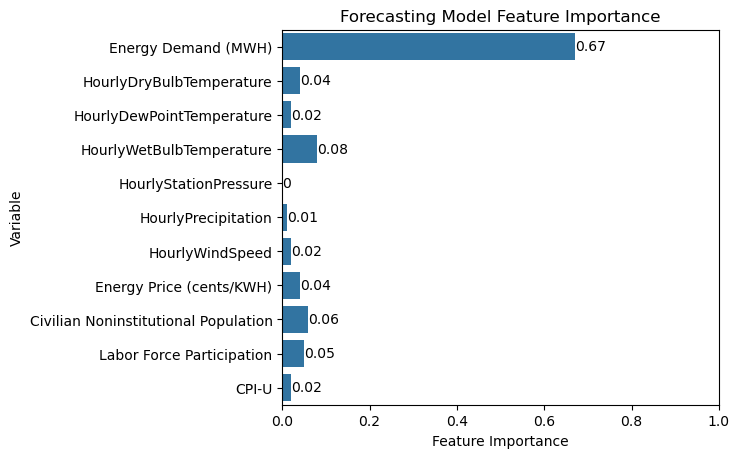

In [22]:
# Sensitivity Analysis for day-ahead forecasts \
feature_importances = pd.Series(mse_diffs)
feature_importances = feature_importances - feature_importances.min()
feature_importances = (feature_importances / feature_importances.sum()).round(2)
sa_fig = plt.figure(figsize=(8,5))
ax = sa_fig.add_subplot()
sns.barplot(x=feature_importances.values, y=feature_importances.index)
ax.bar_label(ax.containers[0])
ax.set_ylabel("Variable")
ax.set_xlabel("Feature Importance")
ax.set_title("Forecasting Model Feature Importance")
ax.set_xlim([0,1])
plt.tight_layout()
pp.save_png_encoded(r'assets/sensitivity_analysis.png', sa_fig)

### Create Report for Download on the Web Application

In [47]:
from plotly.io import to_html
with open(r"assets/model_performance_report.html", "w") as file:
    file.write("""
        <!DOCTYPE html>
        <html>
        <head>
        <title> Energy Demand Forecasting Model Performance Report </title>
        </head>
        <body>
        <H1> Energy Demand Forecasting Model Performance Report </H1>
        <div style="width: 75%;">The following report contains model performance metrics for the NY City Hourly Probabilistic Residential Energy Demand Forecasting Pipeline. 
            Model performance was evaluated on both long-term and day-ahead forecasts. Evaluation was conducted using a holdout dataset of hourly energy 
            demand values between {} and {}.
        <br>
        <H3> Long-Term Forecasting Performance </H3>
        <div style="width: 75%;"> The following table contains performance metrics for the forecasting model compared with a yearly moving average baseline model.</div>
        <div style="width: 75%;">{}</div>
        <br>
        <div style="width: 75%;"> The following Plotly Figure helps to contextualize the forecasting model's performance by showing its predictions along with the actual energy demand 
            values. It also presents the 95% confidence interval bounds estimated by the forecasting model.</div>
        <div style="width: 75%;">{}</div>
        <br> <br> <br>  
        <H3> Day-Ahead Forecasting Performance </H3>
        <div style="width: 75%;"> The following table contains performance metrics for the forecasting model compared with a yearly moving average baseline model.</div>
        <div style="width: 75%;">{}</div>
        <br>
        <divs style="width: 75%;"> The following Plotly Figure helps to contextualize the forecasting model's performance by showing its predictions along with the actual energy demand 
            values. It also presents the 95% confidence interval bounds estimated by the forecasting model. </div>
        <div style="width: 75%;">{}</div>
        <br> <br> <br>
        <H3>Model Sensitivity Analysis</H3>
        <div style="width: 75%;">The following data has been made up for demonstration purposes. Actual data will be provided in a future update.</div>
        <br>
        <img src="{}" width="50%" alt="Sensitivity Analysis">
        </body>
        """.format(evaluation_data.index.min().strftime("%Y-%m-%d"), evaluation_data.index.max().strftime("%Y-%m-%d"), long_results_df.to_html(), 
            to_html(long_term_fig), day_ahead_results_df.to_html(), to_html(short_term_fig), r"sensitivity_analysis.png"))

## Produce Final Model and Predict into the Future

### Fit Model on All Available Data

In [ ]:
# create new processing pipeline to process all data but not create visuals
processor = pp.PreprocessingPipeline(save_datasets=False, produce_eda_plots=False)
final_train_data,_ = processor.process_dataset(preliminary_dataset=preliminary_data, split_into_train_holdout=False)

In [ ]:
# fit final model on all available data
final_model = md.Forecaster()
final_model.fit(clean_training_data=final_train_data, dependent_variable="Energy Demand (MWH)", 
    strong_predictors=["HourlyDryBulbTemperature"], hyperparameters=best_set)

In [ ]:
# Forecast 2 years into the future
future_point_forecasts, future_variance_forecasts = final_model.predict(hours_ahead=365*24*2)

In [ ]:
# produce plot showing 2 year forecast
# Combine error forecasts
std_forecasts = np.sqrt(future_variance_forecasts)

# 1.96 is the z-value for the 2.5th percentile of the standard normal distribution
lower_cuts = future_point_forecasts - 1.96 * std_forecasts  
upper_cuts = future_point_forecasts + 1.96 * std_forecasts

# Create figure showing forecasts and actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=future_point_forecasts, mode='lines', 
    name='Point Forecasts', line=dict(color='rgba(255, 0, 0)')))
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=upper_cuts, mode='lines', 
    name='Upper 95 CI', line=dict(color='rgba(0, 255, 0, 0.2)')))
fig.add_trace(go.Scatter(x=future_point_forecasts.index, y=lower_cuts, mode='lines', 
    name='Lower 95 CI', line=dict(color='rgba(200, 125, 200, 0.2)')))

# Customize the layout
fig.update_layout(
    title="Evaluating Forecasting Pipeline with Holdout Data",
    xaxis_title='Time',
    yaxis_title='Energy Demand (MWH)',
    template='plotly_dark',
    xaxis=dict(range=[future_point_forecasts.index[0],future_point_forecasts.index[-1]])
)

In [ ]:
# save plotly figure for web app
with open(r"Saved/Plotly Figures/Forecasting/future_forecasts.pkl", 'wb') as file:
    pkl.dump(fig, file=file)

# save future forecasts as csv for web app
future_forecasts = pd.concat([future_point_forecasts.rename("Point Forecast"), future_variance_forecasts.rename("Variance Forecast")], 
    axis=1).rename_axis("Time").reset_index()
future_forecasts.to_csv("assets/future_forecasts.csv")